## In-Vehicle coupon recommendation

In [1]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
%pylab inline
import warnings
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

In [3]:
df = pd.read_csv('in-vehicle-coupon-recommendation.CSV')

In [4]:
df.iloc[0]

destination                        No Urgent Place
passanger                                    Alone
weather                                      Sunny
temperature                                     55
time                                           2PM
coupon                             Restaurant(<20)
expiration                                      1d
gender                                        Male
age                                             21
maritalStatus                               Single
has_children                                     0
education                         Bachelors degree
occupation              Architecture & Engineering
income                             $62500 - $74999
Bar                                          never
CoffeeHouse                                  less1
CarryAway                                      4~8
RestaurantLessThan20                           4~8
Restaurant20To50                             less1
toCoupon_GEQ5min               

### Create formula for design matrices

In [5]:
formula = 'Y ~ ' + ' + '.join([''+x+'' \
                                    for x in df.columns.values\
                                    if x != 'Y'])
print(formula)

Y ~ destination + passanger + weather + temperature + time + coupon + expiration + gender + age + maritalStatus + has_children + education + occupation + income + Bar + CoffeeHouse + CarryAway + RestaurantLessThan20 + Restaurant20To50 + toCoupon_GEQ5min + toCoupon_GEQ15min + toCoupon_GEQ25min + direction_same + direction_opp


## Create design matrices

In [6]:
Y, X = dmatrices('Y ~ destination + passanger + weather + temperature + time + coupon + expiration + gender + age + maritalStatus + has_children + education + occupation + income + Bar + CoffeeHouse + CarryAway + RestaurantLessThan20 + Restaurant20To50 + toCoupon_GEQ5min + toCoupon_GEQ15min + toCoupon_GEQ25min + direction_same + direction_opp', df, return_type='dataframe')
y = Y['Y'].values

## Create training and testing sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

## Set up all the classifiers

In [8]:
# All the models we want to test out
models = {}
models['Decision Tree'] = \
    tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)

models['Bagging'] = \
    BaggingClassifier(
        tree.DecisionTreeClassifier(criterion='entropy'),
        random_state=1)

models['Random Forest'] = \
    RandomForestClassifier(n_estimators=10,
                           random_state=1)

models['Gradient Boosting'] = \
    GradientBoostingClassifier(n_estimators=500,
                               max_depth=6,
                               random_state=1)

## Fit the models

In [9]:
for name, model in models.items():
    print('Fitting', name)
    model.fit(X_train, y_train)

Fitting Decision Tree
Fitting Bagging
Fitting Random Forest
Fitting Gradient Boosting


## Accuracy scores

In [10]:
from sklearn import metrics

accuracy_train = {}
accuracy_test = {}
for name, model in models.items():
    prediction_train = model.predict(X_train)
    accuracy_train[name] = metrics.accuracy_score(y_train, prediction_train)
    prediction_test = model.predict(X_test)
    accuracy_test[name] = metrics.accuracy_score(y_test, prediction_test)
    
df = DataFrame({'Training Accuracy':accuracy_train, 'Test Accuracy':accuracy_test})
df

,Training Accuracy,Test Accuracy
Decision Tree,0.791130,0.692881
Bagging,0.982259,0.727925
Random Forest,0.989119,0.698951
Gradient Boosting,0.981668,0.756898


Gradient Boosting gives the best accuracy among all ensemble methods

How does accuracy of gradient boosting depend on the number of trees and their depth?

Text(0, 0.5, 'Test accuracy')

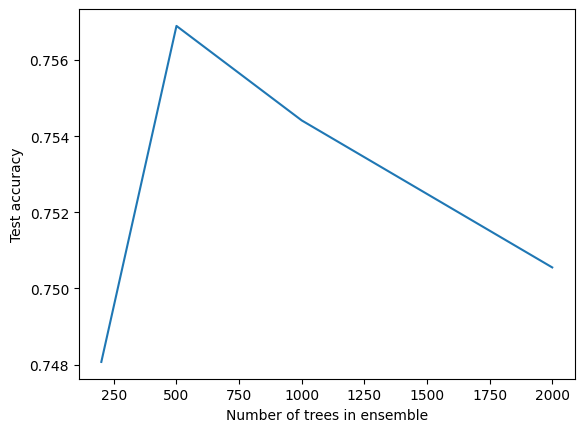

In [11]:
scores = {}
for num_trees in [200, 500, 1000, 2000]:
    model = GradientBoostingClassifier(n_estimators=num_trees,
                                       max_depth=6,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[num_trees] = accuracy_test
Series(scores).sort_index().plot()
xlabel('Number of trees in ensemble')
ylabel('Test accuracy')

500 trees seem to be enough.

How about the depth of the trees?

Text(0, 0.5, 'Test accuracy')

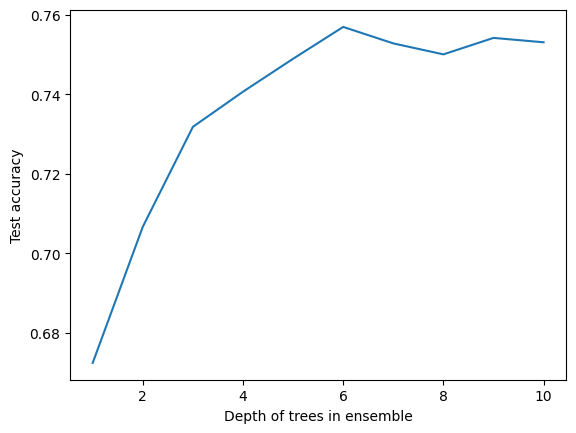

In [12]:
scores = {}
for depth in range(1,11):
    model = GradientBoostingClassifier(n_estimators=500,
                                       max_depth=depth,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[depth] = accuracy_test
Series(scores).sort_index().plot()
xlabel('Depth of trees in ensemble')
ylabel('Test accuracy')

Trees of depth 6 seem to be enough.

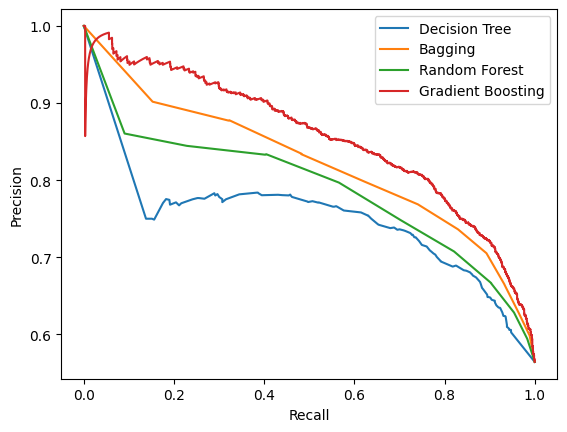

In [13]:
from sklearn.metrics import precision_recall_curve

for index, (name, model) in enumerate(models.items()):
    predictions = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, predictions[:, 1])
    plot(recall, precision, label=name)

xlabel('Recall')
ylabel('Precision')
legend(loc='best')
savefig('Classi.jpg')